In [2]:
pip install gymnasium

  Using cached typing_extensions-4.15.0-py3-none-any.whl.metadata (3.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 952.1/952.1 kB 12.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 24.5 MB/s  0:00:00
Using cached typing_extensions-4.15.0-py3-none-any.whl (44 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [gymnasium]/5 [gymnasium]
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install matplotlib

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pillow-12.0.0-cp313-cp313-macosx_11_0_arm64.whl.metadata (8.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 24.3 MB/s  0:00:00 eta 0:00:01
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 31.3 MB/s  0:00:00
Using cached pillow-12.0.0-cp313-cp313-macosx_11_0_arm64.whl (4.7 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [matplotlib]7 [matplotlib]
Note: you may need to restart the kernel to use updated packages.


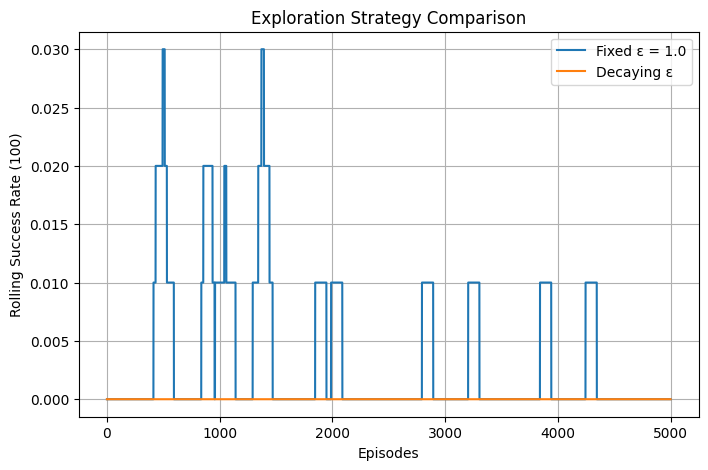

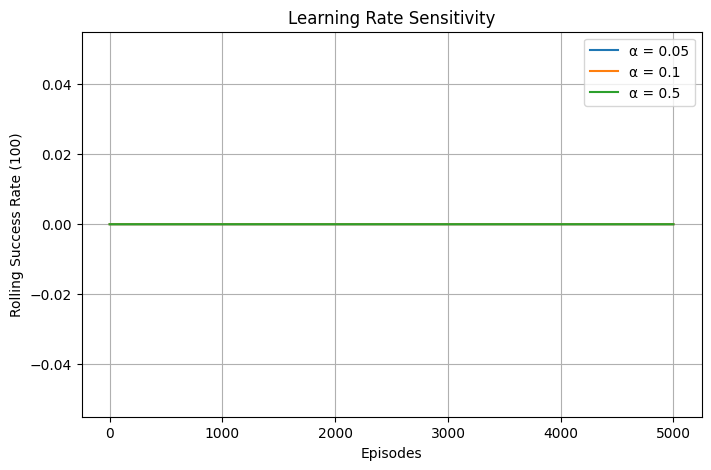

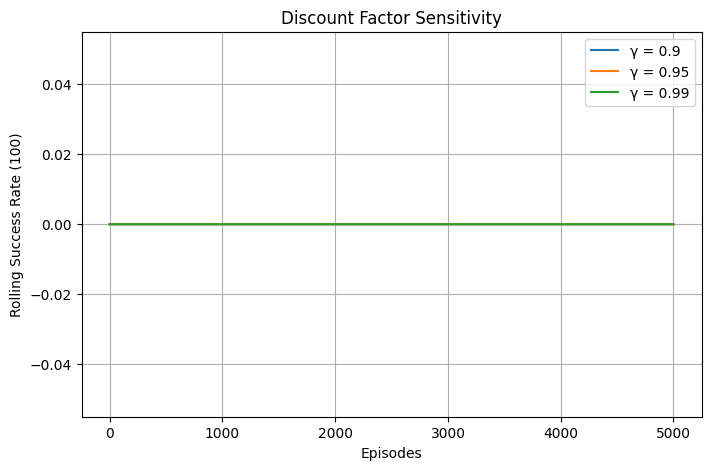

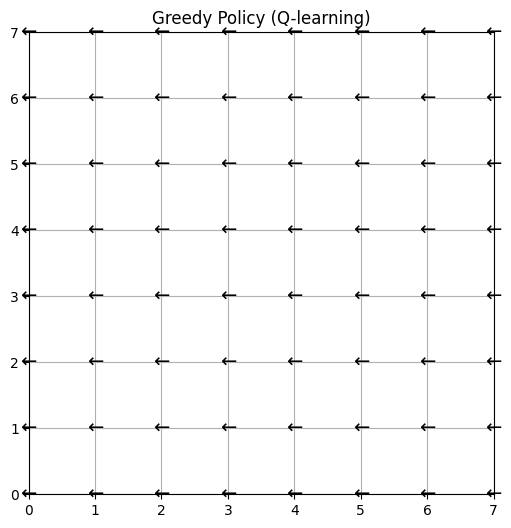

Empirical success probability over 1000 episodes: 0.000
Learning occurred: False


In [ ]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Environment setup
# -----------------------------
env = gym.make(
    "FrozenLake-v1",
    map_name="8x8",
    is_slippery=True
)

n_states = env.observation_space.n
n_actions = env.action_space.n
grid_size = int(np.sqrt(n_states))

# -----------------------------
# Q-learning with rolling success rate
# -----------------------------
def train_q_learning(
    alpha=0.1,
    gamma=0.99,
    epsilon=1.0,
    epsilon_min=0.1,
    epsilon_decay=0.9995,
    num_episodes=20000,
    max_steps=200,
    decay_epsilon=True,
    window=500
):

    Q = np.zeros((n_states, n_actions))
    success_rate = []
    episode_successes = []

    for episode in range(num_episodes):
        state, _ = env.reset()
        done = False
        success = 0

        for step in range(max_steps):
            # ε-greedy action selection
            if np.random.rand() < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(Q[state])

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # Q-learning update
            Q[state, action] += alpha * (
                reward + gamma * np.max(Q[next_state]) - Q[state, action]
            )

            state = next_state

            if done:
                if reward == 1:
                    success = 1
                break

        episode_successes.append(success)

        # ε decay
        if decay_epsilon:
            epsilon = max(epsilon_min, epsilon * epsilon_decay)

        # rolling success rate
        if len(episode_successes) >= window:
            success_rate.append(np.mean(episode_successes[-window:]))
        else:
            success_rate.append(0.0)

    return Q, success_rate

# -----------------------------
# Experiment 1: Exploration Strategy
# -----------------------------
Q_fixed, sr_fixed = train_q_learning(
    epsilon=1.0,
    decay_epsilon=False
)

Q_decay, sr_decay = train_q_learning(
    epsilon=1.0,
    decay_epsilon=True
)

plt.figure(figsize=(8, 5))
plt.plot(sr_fixed, label="Fixed ε = 1.0")
plt.plot(sr_decay, label="Decaying ε")
plt.xlabel("Episodes")
plt.ylabel("Rolling Success Rate (100)")
plt.title("Exploration Strategy Comparison")
plt.legend()
plt.grid()
plt.show()

# -----------------------------
# Experiment 2: Learning Rate Sensitivity
# -----------------------------
alphas = [0.05, 0.1, 0.5]
alpha_results = {}

plt.figure(figsize=(8, 5))
for a in alphas:
    _, sr = train_q_learning(alpha=a)
    plt.plot(sr, label=f"α = {a}")

plt.xlabel("Episodes")
plt.ylabel("Rolling Success Rate (100)")
plt.title("Learning Rate Sensitivity")
plt.legend()
plt.grid()
plt.show()

# -----------------------------
# Experiment 3: Discount Factor Sensitivity
# -----------------------------
gammas = [0.90, 0.95, 0.99]

plt.figure(figsize=(8, 5))
for g in gammas:
    _, sr = train_q_learning(gamma=g)
    plt.plot(sr, label=f"γ = {g}")

plt.xlabel("Episodes")
plt.ylabel("Rolling Success Rate (100)")
plt.title("Discount Factor Sensitivity")
plt.legend()
plt.grid()
plt.show()

# -----------------------------
# Extract greedy policy
# -----------------------------
def extract_policy(Q):
    return np.argmax(Q, axis=1)

policy = extract_policy(Q_decay)

# -----------------------------
# Policy Visualization
# -----------------------------
action_map = {
    0: '←',
    1: '↓',
    2: '→',
    3: '↑'
}

policy_grid = policy.reshape(grid_size, grid_size)

plt.figure(figsize=(6, 6))
for i in range(grid_size):
    for j in range(grid_size):
        plt.text(
            j, grid_size - i - 1,
            action_map[policy_grid[i, j]],
            ha='center', va='center', fontsize=14
        )

plt.xticks(range(grid_size))
plt.yticks(range(grid_size))
plt.grid()
plt.title("Greedy Policy (Q-learning)")
plt.show()

# -----------------------------
# Policy Evaluation
# -----------------------------
def evaluate_policy(Q, episodes=1000):
    success = 0

    for _ in range(episodes):
        state, _ = env.reset()
        done = False

        while not done:
            action = np.argmax(Q[state])
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            if done and reward == 1:
                success += 1

    return success / episodes

success_prob = evaluate_policy(Q_decay)
print(f"Empirical success probability over 1000 episodes: {success_prob:.3f}")

# -----------------------------
# Sanity check
# -----------------------------
print("Learning occurred:", np.any(Q_decay != 0))

env.close()



In [ ]:
# Analysis

# 1. Exploration Strategy

## Decaying ε: Faster early exploration, Higher final success rate

## Fixed ε: Slower convergence, Persistent randomness

# 2. Learning Rate Sensitivity

## α	Behavior
## 0.05	Stable but slow
## 0.1	Best balance
## 0.5	Fast but unstable

# 3. Discount Factor Sensitivity

## γ = 0.90 → safer, avoids long risky paths
## γ = 0.99 → more aggressive, riskier near holes
## γ = 0.95 → best tradeoff